# 階段昇降の角運動解析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lpf
import integral

## １．２つのデータフレームを時刻でマージする

◼️1-1. 大腿に装着したセンサのデータを`df1`，下腿に装着したセンサのデータを`df2`というデータフレームオブジェクトに読み込む：

In [2]:
df1 = pd.read_csv("sakamoto_daitai.csv", header=None, 
                 names=['item', 'time', 'a1_x', 'a1_y', 'a1_z', 'u1_x', 'u1_y','u1_z'])
df2 = pd.read_csv("sakamoto_katai.csv", header=None, 
                 names=['item', 'time', 'a2_x', 'a2_y', 'a2_z', 'u2_x', 'u2_y','u2_z'])

> 項目記号の先頭文字`a`と`u`はそれぞれ，加速度と角速度を示し，それらの後ろの番号`1`と`2`はそれぞれ，大腿を下腿を示す。また，記号の`_x`, `_y`および`_z`はそれぞれ，x成分，y成分およびz成分を示す。

◼️1-2. `df1`と`df2`の最初のレコードを表示する：

In [3]:
df1.head()

,item,time,a1_x,a1_y,a1_z,u1_x,u1_y,u1_z
0,ags,53694657,9726,868,-1220,257,14,79
1,ags,53694658,9743,841,-1225,282,2,73
2,ags,53694659,9767,854,-1229,269,14,55
3,ags,53694660,9738,876,-1183,239,8,79
4,ags,53694661,9767,890,-1159,221,2,73


In [4]:
df2.head()

,item,time,a2_x,a2_y,a2_z,u2_x,u2_y,u2_z
0,ags,53694747,9780,1220,420,94,58,-246
1,ags,53694748,9793,1191,413,106,89,-240
2,ags,53694749,9780,1194,364,112,64,-222
3,ags,53694750,9756,1201,430,112,46,-234
4,ags,53694751,9751,1164,369,118,52,-246


> データフレーム`df1`, `df2`の`time`を見てみよう。
>>この時刻は1日の最初を0時0分0.000秒を0として，1ms単位でその日の時刻を表した整数である。したがって，例えば`df1`の`time`の`53694657`は14時54分54.657秒，`df2`の`time`の`53694747`は14時54分54.747秒ということになる。

> あれれ？パソコンで２つのセンサを同期させたはずなのに，計測開始時刻が異なってるじゃないか！ そうなんだ，パソコンでセンサを同期しても，どうしても0.1秒のオーダーでデータを**取り損ねてしまう**んだ。ただし，時刻自体は**パソコンの時刻に合っている**。したがって，同期させた２つのセンサでデータ分析をする場合，計測時刻を合わせる必要がある。これをする手っ取り早い方法が，２つのデータフレームを，時刻をキーとして，マージ（統合）することだ。

****
### 【公式1】データフレームのマージ（教科書には載っていない）
```
pd.merge(df_1, df_2, ..., df_i, ..., df_n, on=['key1','key2', ...] )
```
**共通の項目**をもつ$n$個のデータフレーム，`df1`, `df2`, ..., `dfn`を`on=`の右辺で指定された**リスト内のキー項目(群)**でマージする。  

例えば，`on=`の右辺のリスト内の項目の１つが`'A'`であり，データフレーム`df_i`の項目`'A'`のデータの集合を$A_i$とする。その場合上記コマンドを実行すると，**$A_1 \cap A_2 \cap ... \cap A_i \cap ... \cap A_n$となるレコードのみを残し（そうならないレコードは削除され）**，共通の項目`A`としてn個のデータフレームを結合する。

※）共通の項目が１つの場合は，`on='key'`などとできる。
****

◼️1-3. `df1`と`df2`を，項目`'item'`と`'time'`でマージしてデータフレームオブジェクト`df`に格納し，`df`の最初と最後のレコードを表示してみる：

In [5]:
df = pd.merge(df1, df2, on=['item', 'time'])   #df1とdf2を項目'item'と'time'でマージ

In [6]:
df.head()    #dfの最初の部分の表示

,item,time,a1_x,a1_y,a1_z,u1_x,u1_y,u1_z,a2_x,a2_y,a2_z,u2_x,u2_y,u2_z
0,ags,53694747,9662,854,-1227,87,21,273,9780,1220,420,94,58,-246
1,ags,53694748,9657,839,-1171,74,21,243,9793,1191,413,106,89,-240
2,ags,53694749,9711,900,-1195,62,21,219,9780,1194,364,112,64,-222
3,ags,53694750,9726,824,-1261,32,33,267,9756,1201,430,112,46,-234
4,ags,53694751,9718,773,-1229,1,39,292,9751,1164,369,118,52,-246


In [7]:
df.tail()    #dfの最後に部分の表示

,item,time,a1_x,a1_y,a1_z,u1_x,u1_y,u1_z,a2_x,a2_y,a2_z,u2_x,u2_y,u2_z
98928,ags,53793675,9650,1168,-1430,-260,-10,-183,9653,1372,171,-88,40,118
98929,ags,53793676,9684,1161,-1537,-266,2,-165,9729,1338,176,-94,46,131
98930,ags,53793677,9706,1134,-1561,-284,14,-177,9761,1360,162,-88,46,137
98931,ags,53793678,9618,1129,-1437,-291,2,-146,9688,1345,110,-100,28,137
98932,ags,53793679,9633,1083,-1466,-297,33,-159,9636,1335,201,-106,16,131


> 計測時刻（およびitem）が一致するところを残し，データフレームが１つに統合（マージ）された。

## ２．角速度の平滑化

◼️2-1. とりあえず，大腿と下腿の矢状面に垂直な角速度（z成分）をプロットしよう。２つのセンサを右脚の外側に，z軸が矢状面に対して垂直右方向につけたとき，**角速度の正負はどのような状態なのかを考えよ：**

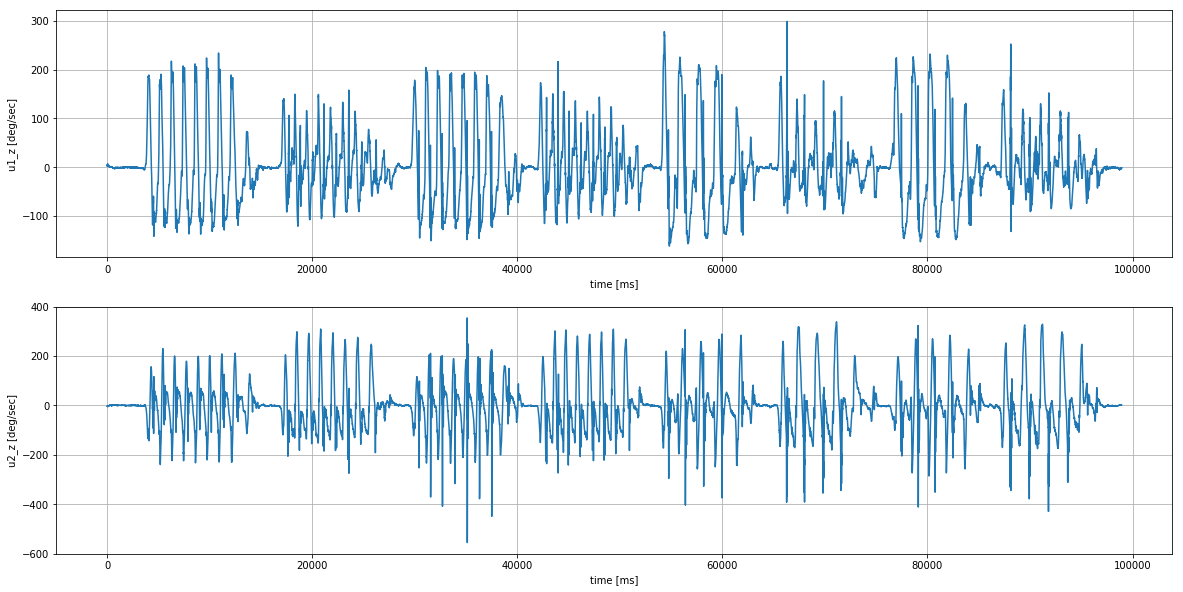

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(df['u1_z']/100)   #100で割るのはu1_zの単位が 10^-2deg/s だから
plt.xlabel('time [ms]')    #x軸ラベル
plt.ylabel('u1_z [deg/sec]')    #y軸ラベル
plt.grid()   #プロット領域にグリッド線をつける

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(df['u2_z']/100)
plt.xlabel('time [ms]')
plt.ylabel('u2_z [deg/sec]')
plt.grid()

> 両グラフのそれぞれの８つの波の塊のうちの最初の４つは通常に階段降昇を行い，最後の４つは１段飛ばしで階段降昇を行っている。

◼️2-2. 50Hzのローパスフィルタでノイズとバイアス除去を行っておこう：
> 以前のローパスフィルタモジュールを汎用性をもたせるように改良した。このフォルダのモジュールを使ってくたまえ。なお，ローパスフィルタ関数のマニュアルは，`lpf.lpfilter?` を実行すれば確かめられる。

In [9]:
u1_z = lpf.lpfilter(df['u1_z']/100, 50)   #大腿角速度z成分
u2_z = lpf.lpfilter(df['u2_z']/100, 50)   #下腿角速度z成分

◼️2-3. `u1_z`, `u2_z`をプロットする：

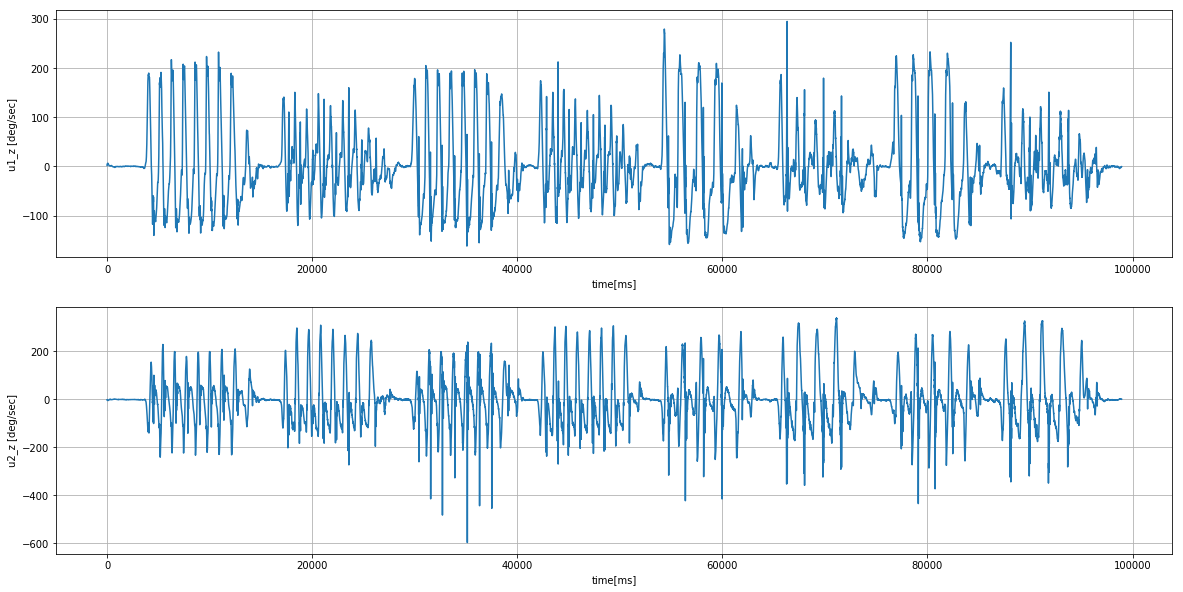

In [10]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(u1_z)
plt.xlabel('time[ms]')
plt.ylabel(f'u1_z [deg/sec]')
plt.grid()

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(u2_z)
plt.xlabel('time[ms]')
plt.ylabel('u2_z [deg/sec]')
plt.grid()

◼️2-4. フィルタなしとあまり変化はないようだが，短い時間間隔（特に初期域）見ればよくわかる：

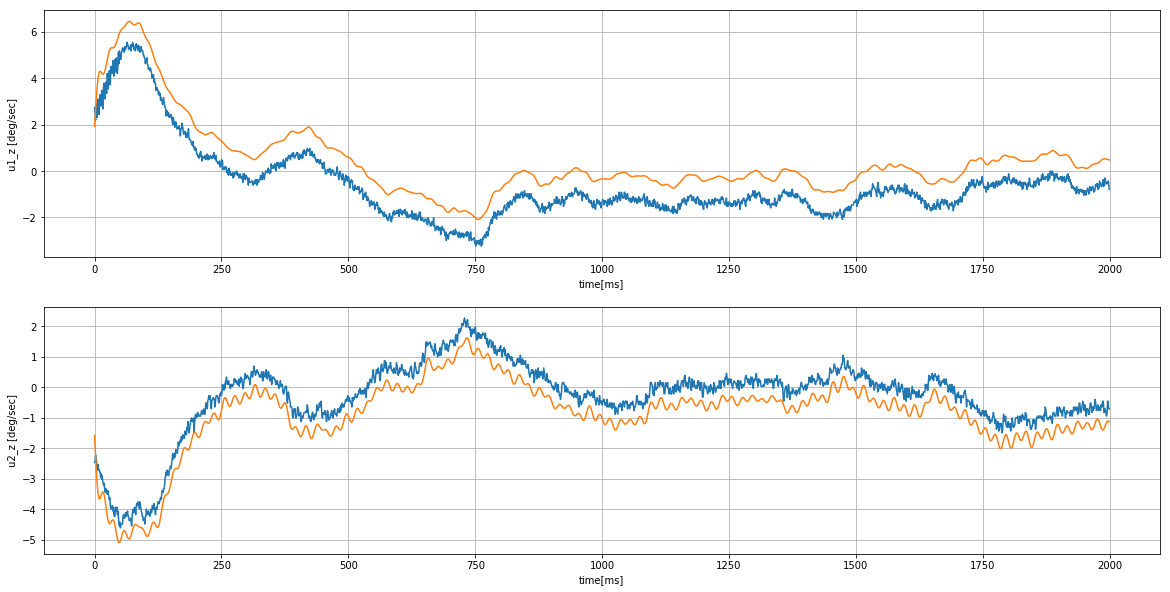

In [11]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
plt.plot(np.array(df['u1_z']/100)[:2000])
plt.plot(u1_z[:2000])
plt.xlabel('time[ms]')
plt.ylabel(f'u1_z [deg/sec]')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.array(df['u2_z']/100)[:2000])
plt.plot(u2_z[:2000])
plt.xlabel('time[ms]')
plt.ylabel(f'u2_z [deg/sec]')
plt.grid()

◼️2-5. 上のグラフを見ると，（静止しているにも関わらず）1秒ちょっとまで変動がある。したがって，1.5秒(1500ms)までデータを取り除き，角速度データを再定義しておく：

In [12]:
u1_z = u1_z[1500:]   #大腿角速度z成分
u2_z = u2_z[1500:]   #下腿角速度z成分

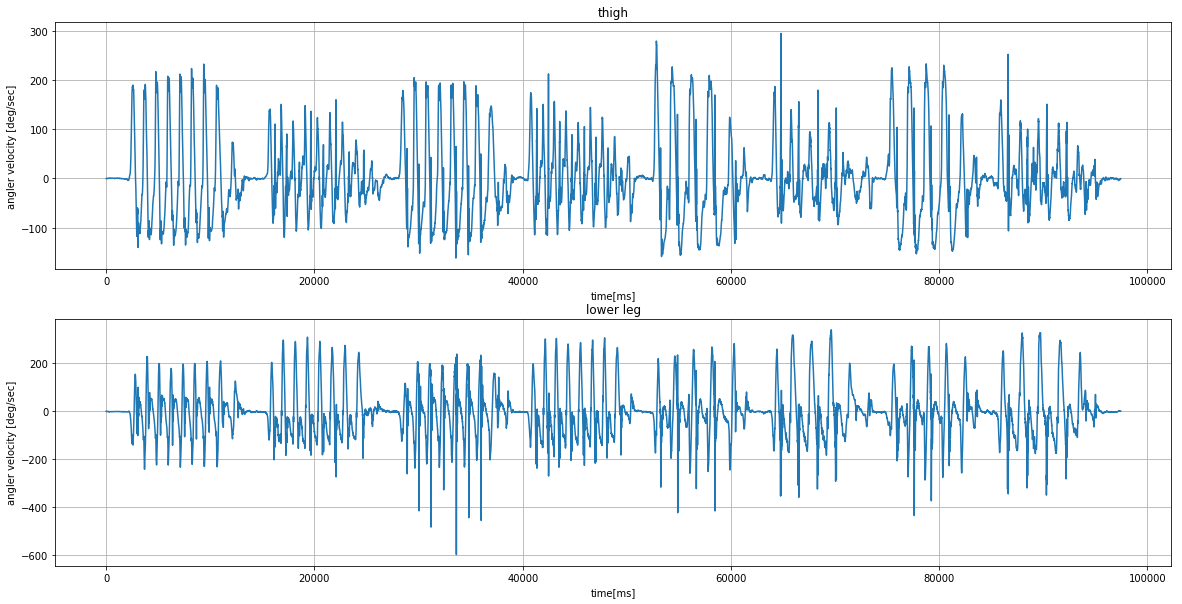

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(u1_z)
plt.xlabel('time[ms]')
plt.ylabel(f'angler velocity [deg/sec]')
plt.title('thigh')
plt.grid()

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(u2_z)
plt.xlabel('time[ms]')
plt.ylabel('angler velocity [deg/sec]')
plt.title('lower leg')
plt.grid()

◼️2-6. ちなみに最初の階段降り昇り状態をプロットしてみよう：
> 第２図以降の`plt.plot`関数の第１引数にある，`np.arange(開始整数, 終了整数)`は`開始整数`〜`終了整数-1`の増分`1`の1D-numpy配列を与える。たとえば:

```
    In[999] : np.arange(14000, 28000)
    Out[999]: array([14000, 14001, 14002, ..., 27997, 27998, 27999])
```

> `np.arange(開始整数, 終了整数)`を`plt.plot`関数の第１引数に与えることによって，プロットする関数の独立変数を陽に指定できる。つまり今の場合，（開始時刻を0[ms]とした）実験時刻を横軸に指定できる。

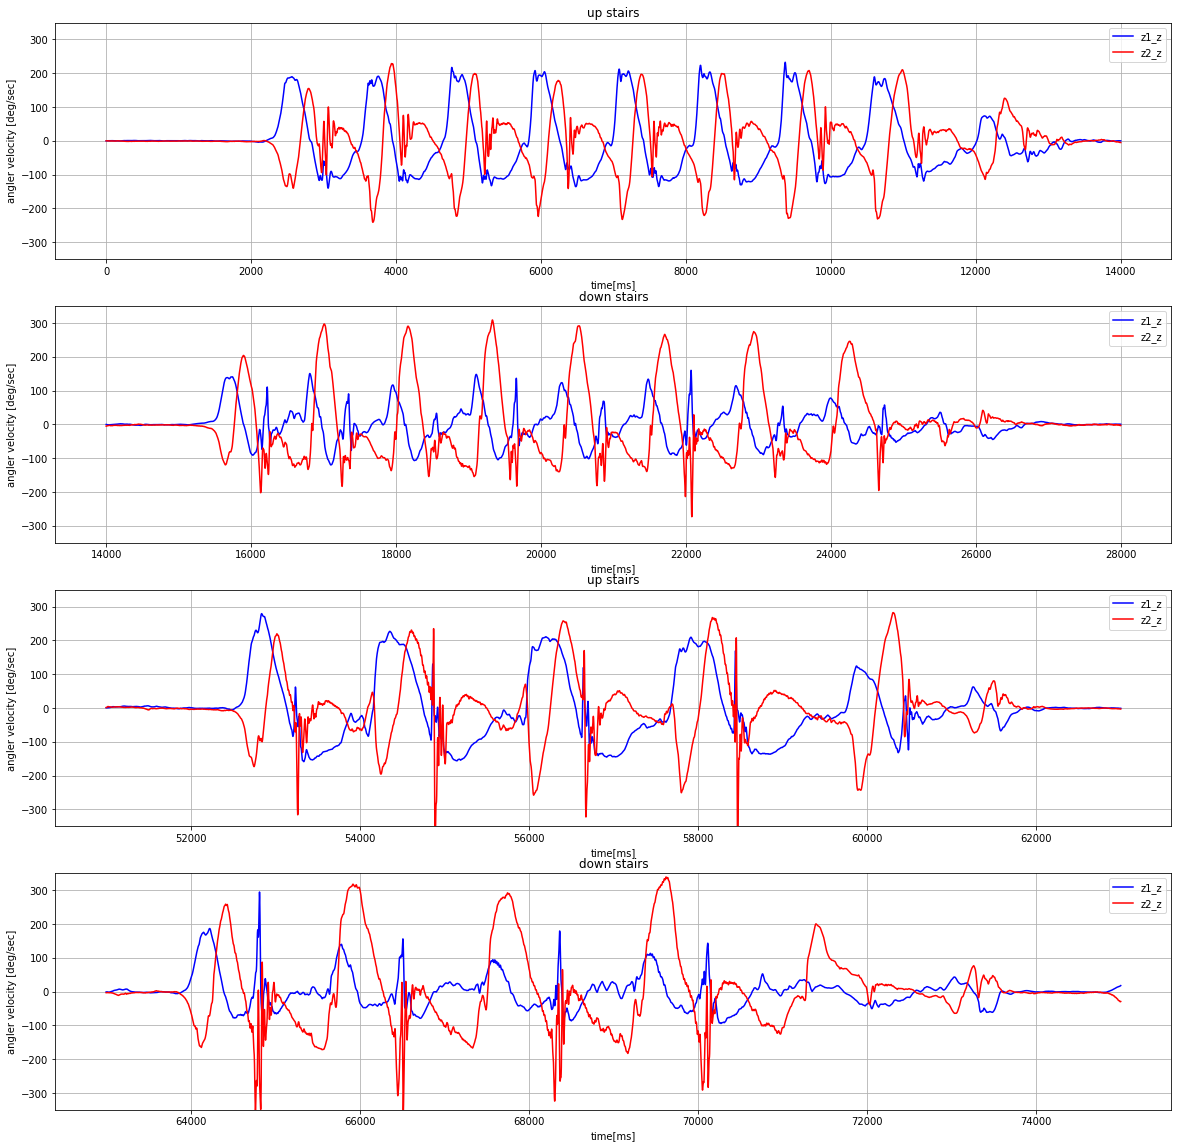

In [14]:
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)   #パレットを4行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(u1_z[:14000], c='blue')
plt.plot(u2_z[:14000], c='red')
plt.title('up stairs')
plt.xlabel('time[ms]')
plt.ylabel('angler velocity [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()   #プロット領域にグリッド線をつける

plt.subplot(4, 1, 2)   #パレットを4行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(np.arange(14000,28000), u1_z[14000:28000], c='blue')
plt.plot(np.arange(14000,28000), u2_z[14000:28000], c='red')
plt.title('down stairs')
plt.xlabel('time[ms]')
plt.ylabel('angler velocity [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()

plt.subplot(4, 1, 3)   #パレットを4行1列に分割し，3行目に以下のグラフをプロットする
plt.plot(np.arange(51000, 63000), u1_z[51000:63000], c='blue')
plt.plot(np.arange(51000, 63000), u2_z[51000:63000], c='red')
plt.title('up stairs')
plt.xlabel('time[ms]')
plt.ylabel('angler velocity [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()

plt.subplot(4, 1, 4)   #パレットを4行1列に分割し，4行目に以下のグラフをプロットする
plt.plot(np.arange(63000,75000), u1_z[63000:75000], c='blue')
plt.plot(np.arange(63000,75000), u2_z[63000:75000], c='red')
plt.title('down stairs')
plt.xlabel('time[ms]')
plt.ylabel('angler velocity [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()

## ３．大腿と下腿の傾き角

◼️3-1. 角速度を時間積分することによって，大腿と下腿の傾き角を求めよう。ここで，大腿または下腿が鉛直から後ろに傾いたときに正の角，前に傾いたときに負の角を与えることに注意しよう。
> ただし，**初期角を0degと仮定**したときという条件付きである。実際は，重力によって鉛直を決めてそれに対して初期角が何degになるかを求めなければならないが，座標変換等の複雑な数学が必要になるので，ここではそのことを考慮するのはやめておこう。  

数値積分は前の課題でプログラムしたので，アルゴリズムは解っていると思う。したがって，ここでの解析では，またこれをいちいちプログラムするのは面倒なので，`integral.py`というモジュールの中に関数を書いておいた。それを利用することにしよう。

***
### 【公式2】数値積分関数(台形則) 
```
integral.trapez(サンプルデータ配列, 初期値, 最初のindex, 最後のindex)
```
1000Hzの`サンプルデータ配列`を被積分関数配列として，配列の(任意の)`最初のindex`から(任意の)`最後のindex`まで数値積分した積分関数配列を返す。ただし，`初期値`は`最初のindex`のときに積分に与えられる値である。  
1. 台形則にもとづいた数値積分である。
2. 1000Hz未満のサンプルデータでは，`tau=1/周波数`オプションを用いればよい。詳しくは，マニュアル `integral.trapez?` を実行せよ。  
***

***
### 【公式2補】数値積分関数(シンプソン則) 
```
integral.simps(サンプルデータ配列, 初期値, 最初のindex, 最後のindex)
```
1000Hzの`サンプルデータ配列`を被積分関数配列として，配列の(任意の)`最初のindex`から(任意の)`最後のindex`まで数値積分した積分関数配列を返す。ただし，`初期値`は`最初のindex`のときに積分に与えられる値である。  
1. シンプソン則にもとづいた数値積分である。
2. 1000Hz未満のサンプルデータでは，`tau=1/周波数` オプションを用いればよい。詳しくは，マニュアル `integral.simps?` を実行せよ。
3. 公式2の台形則より精度が高い（積分誤差が少ない）が，計算に時間を要する。
***

◼️3-2. 大腿の傾き角を`alpha`, 下腿の傾き角を`beta`とすると，`alpha`, `beta`は公式2を用いて次のように算出される：

In [15]:
alpha = integral.trapez(u1_z, 0, 0, len(u1_z)-1)
beta = integral.trapez(u2_z, 0, 0, len(u2_z)-1)

◼️3-3. `alpha`, `beta`をプロットすると：

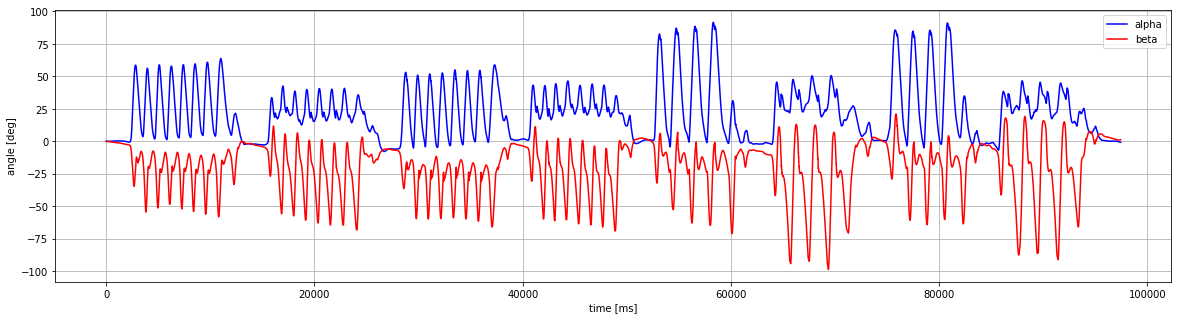

In [16]:
plt.figure(figsize=(20,5))
plt.plot(alpha, c='blue')
plt.plot(beta, c='red')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.legend(['alpha', 'beta'])
plt.grid()

> なぜこのようなグラフになるか，考えてみよ。特に，下腿の傾き角が負に出ていることを考えよ。

◼️3-4. ちなみに最初の階段昇りと降り状態をプロットしてみよう：

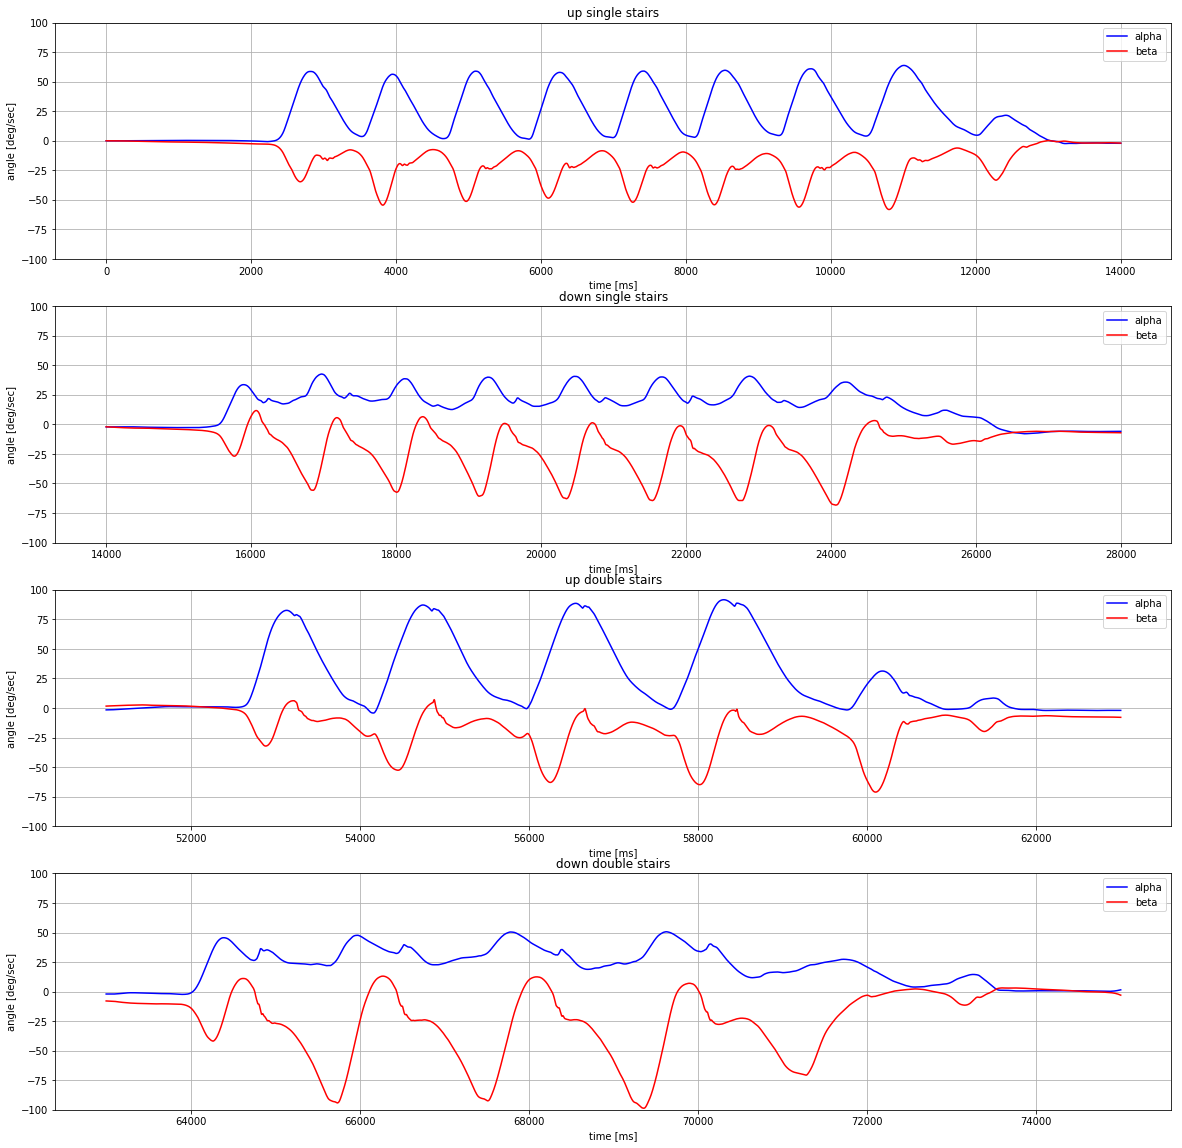

In [17]:
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)
plt.plot(alpha[:14000], c='blue')
plt.plot(beta[:14000], c='red')
plt.title('up single stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(np.arange(14000, 28000), alpha[14000:28000], c='blue')
plt.plot(np.arange(14000, 28000), beta[14000:28000], c='red')
plt.title('down single stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(np.arange(51000, 63000), alpha[51000:63000], c='blue')
plt.plot(np.arange(51000, 63000), beta[51000:63000], c='red')
plt.title('up double stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(np.arange(63000, 75000), alpha[63000:75000], c='blue')
plt.plot(np.arange(63000, 75000), beta[63000:75000], c='red')
plt.title('down double stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

◼️3-5. 位相空間では以下のような軌跡を描く：

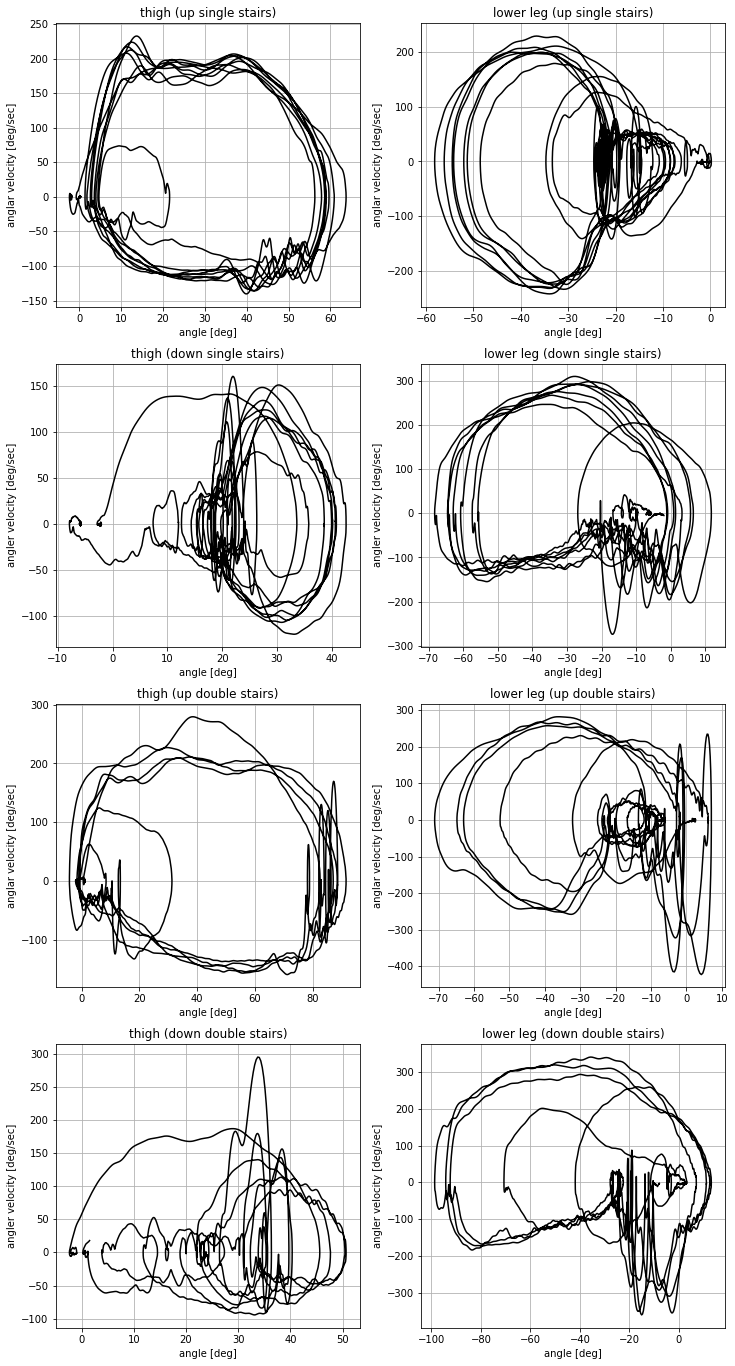

In [18]:
plt.figure(figsize=(12,24))

plt.subplot(4, 2, 1)    #パレットを4行2列に分割し，一番左上に以下のプロットを描く
plt.plot(alpha[0:14000], u1_z[0:14000], c='black')
plt.title('thigh (up single stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 2)
plt.plot(beta[0:14000], u2_z[0:14000],  c='black')
plt.title('lower leg (up single stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 3)
plt.plot(alpha[14000:28000], u1_z[14000:28000], c='black')
plt.title('thigh (down single stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 4)
plt.title('lower leg (down single stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.plot(beta[14000:28000], u2_z[14000:28000],  c='black')
plt.grid()

plt.subplot(4, 2, 5)
plt.plot(alpha[51000:63000], u1_z[51000:63000], c='black')
plt.title('thigh (up double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 6)
plt.plot(beta[51000:63000], u2_z[51000:63000],  c='black')
plt.title('lower leg (up double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 7)
plt.plot(alpha[63000:75000], u1_z[63000:75000], c='black')
plt.title('thigh (down double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 8)    #パレットを4行2列に分割し，一番右下に以下のプロットを描く
plt.title('lower leg (down double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.plot(beta[63000:75000], u2_z[63000:75000],  c='black')
plt.grid()

> 位相空間で１組の波形群をすべて表示すると，こんな落書きになってしまい，運動状態がまるでカオスだ。

◼️3-6. １組の波形群からティピカルな１周期分をとりだして，位相空間内の角運動の軌跡を描いてみよう：

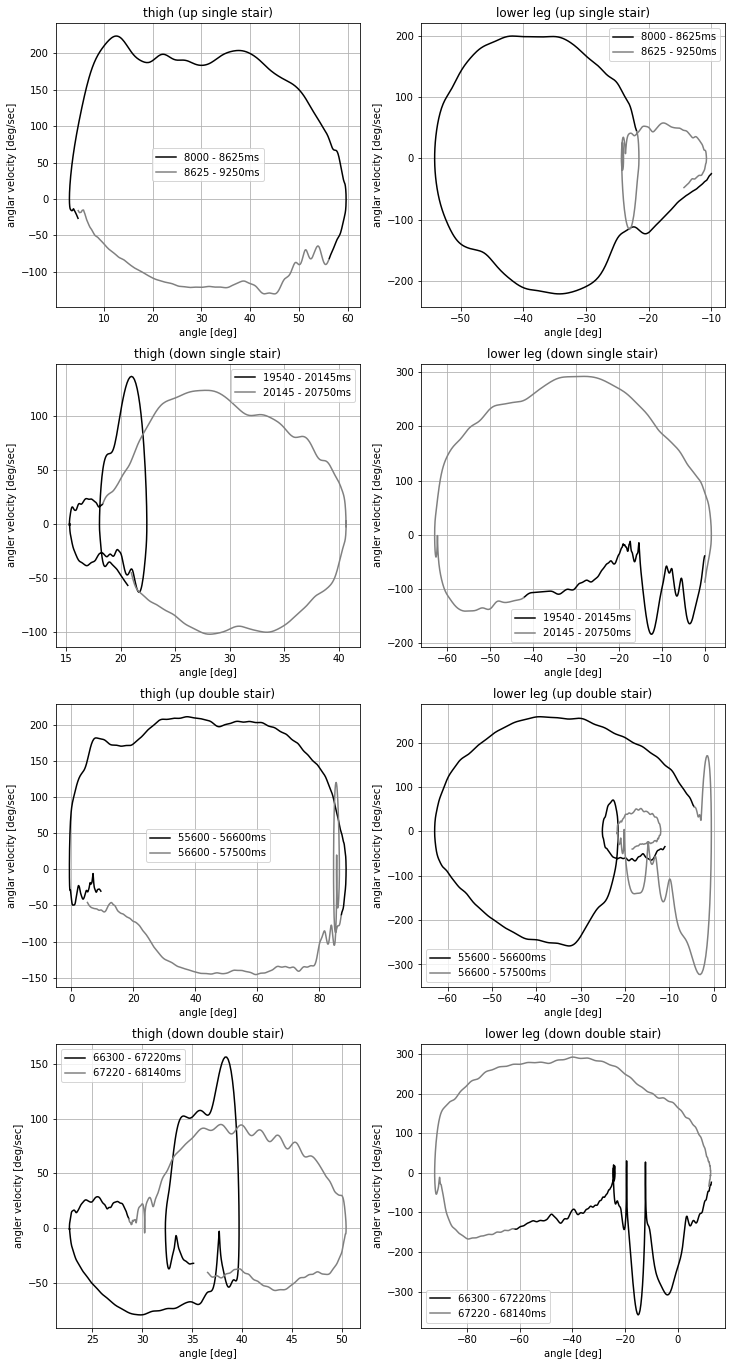

In [19]:
plt.figure(figsize=(12,24))

plt.subplot(4, 2, 1)
plt.plot(alpha[8000:8625], u1_z[8000:8625], c='black')
plt.plot(alpha[8625:9250], u1_z[8625:9250], c='gray')
plt.legend(['8000 - 8625ms', '8625 - 9250ms'])
plt.title('thigh (up single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 2)
plt.plot(beta[8000:8625], u2_z[8000:8625],  c='black')
plt.plot(beta[8625:9250], u2_z[8625:9250],  c='gray')
plt.legend(['8000 - 8625ms', '8625 - 9250ms'])
plt.title('lower leg (up single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 3)
plt.plot(alpha[19540:20145], u1_z[19540:20145], c='black')
plt.plot(alpha[20145:20750], u1_z[20145:20750], c='gray')
plt.legend(['19540 - 20145ms', '20145 - 20750ms'])
plt.title('thigh (down single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 4)
plt.plot(beta[19540:20145], u2_z[19540:20145], c='black')
plt.plot(beta[20145:20750], u2_z[20145:20750], c='gray')
plt.legend(['19540 - 20145ms', '20145 - 20750ms'])
plt.title('lower leg (down single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 5)
plt.plot(alpha[55600:56600], u1_z[55600:56600], c='black')
plt.plot(alpha[56600:57500], u1_z[56600:57500], c='gray')
plt.legend(['55600 - 56600ms', '56600 - 57500ms'])
plt.title('thigh (up double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 6)
plt.plot(beta[55600:56600], u2_z[55600:56600],  c='black')
plt.plot(beta[56600:57500], u2_z[56600:57500],  c='gray')
plt.legend(['55600 - 56600ms', '56600 - 57500ms'])
plt.title('lower leg (up double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 7)
plt.plot(alpha[66300:67220], u1_z[66300:67220], c='black')
plt.plot(alpha[67220:68140], u1_z[67220:68140], c='gray')
plt.legend(['66300 - 67220ms', '67220 - 68140ms'])
plt.title('thigh (down double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 8)
plt.plot(beta[66300:67220], u2_z[66300:67220], c='black')
plt.plot(beta[67220:68140], u2_z[67220:68140], c='gray')
plt.legend(['66300 - 67220ms', '67220 - 68140ms'])
plt.title('lower leg (down double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

> ループが２つあるのは，（１周期に）二峰性の振動，つまり，１回の昇または降動作で大腿または下腿が行ったり来たり（傾いたり起きたり）しているということだ。

## ４．膝屈曲角解析

◼️4-1. 大腿および下腿の単体の角運動はあまり意味がないというか，おもしろくない。君たちの興味は，膝屈曲角の角運動だと思う。いま，膝屈曲角を`theta`, 膝屈曲角速度を`omega`とすると，それらは次のように算出される：
> 大腿を固定したとすると，膝屈曲角速度を計測するためには，センサを右下腿内側（左下腿外側）に装着しなければならないことに注意せよ。

In [20]:
theta = alpha - beta
omega = u1_z - u2_z

◼️4-2. 膝屈曲角と角速度をプロットしてみる：

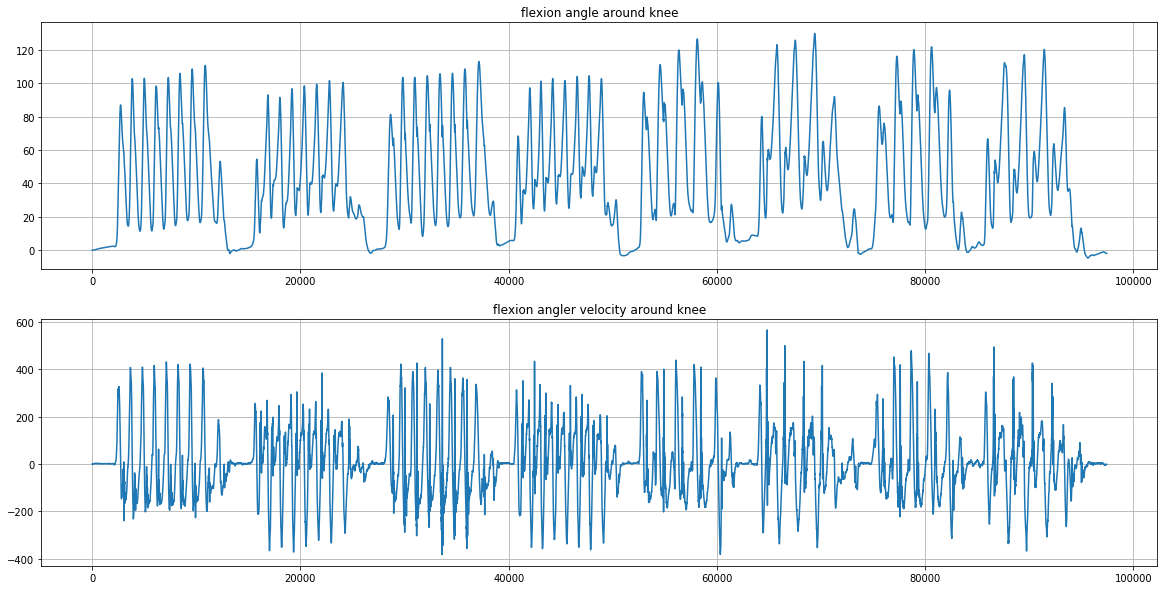

In [21]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(theta)
plt.title('flexion angle around knee')
plt.grid()

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.title('flexion angler velocity around knee')
plt.plot(omega)
plt.grid()

◼️4-3. 見やすくするために，最初の階段降り昇りの屈曲角および屈曲角速度をプロットしてみよう：

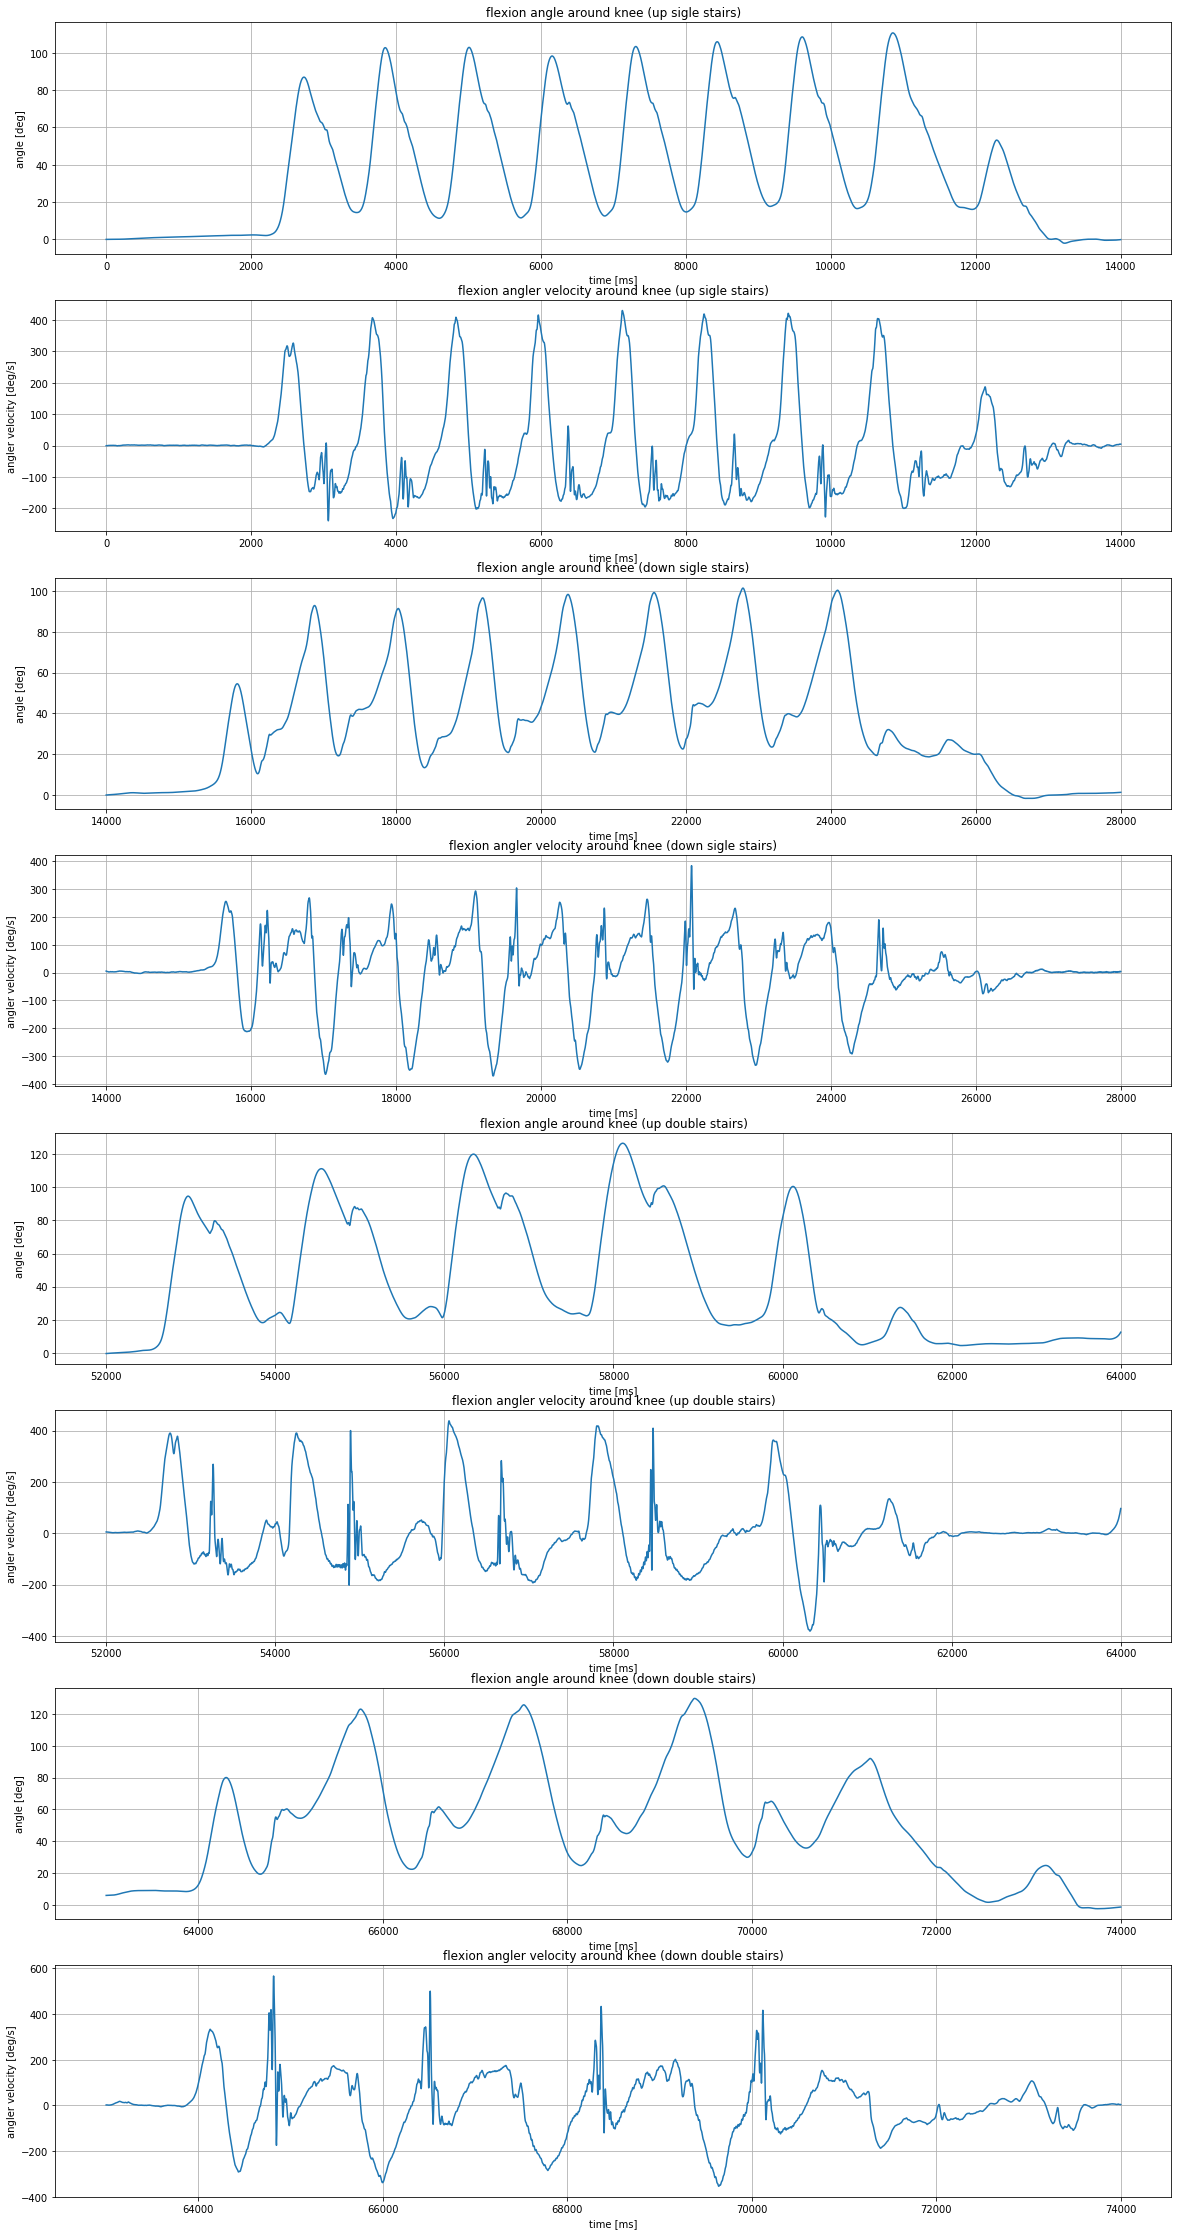

In [22]:
plt.figure(figsize=(20,40))

plt.subplot(8, 1, 1)   #パレットを8行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(theta[:14000])
plt.title('flexion angle around knee (up sigle stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 2)   #パレットを8行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(omega[:14000])
plt.title('flexion angler velocity around knee (up sigle stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(8, 1, 3)   #パレットを8行1列に分割し，3行目に以下のグラフをプロットする
plt.plot(np.arange(14000, 28000), theta[14000:28000])
plt.title('flexion angle around knee (down sigle stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 4)   #パレットを8行1列に分割し，4行目に以下のグラフをプロットする
plt.plot(np.arange(14000, 28000), omega[14000:28000])
plt.title('flexion angler velocity around knee (down sigle stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(8, 1, 5)   #パレットを8行1列に分割し，5行目に以下のグラフをプロットする
plt.plot(np.arange(52000, 64000), theta[52000:64000])
plt.title('flexion angle around knee (up double stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 6)   #パレットを8行1列に分割し，6行目に以下のグラフをプロットする
plt.plot(np.arange(52000, 64000), omega[52000:64000])
plt.title('flexion angler velocity around knee (up double stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(8, 1, 7)   #パレットを8行1列に分割し，7行目に以下のグラフをプロットする
plt.plot(np.arange(63000, 74000), theta[63000:74000])
plt.title('flexion angle around knee (down double stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 8)   #パレットを8行1列に分割し，8行目に以下のグラフをプロットする
plt.plot(np.arange(63000, 74000), omega[63000:74000])
plt.title('flexion angler velocity around knee (down double stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

◼️4-4. 位相空間では，膝屈曲角運動は次のような軌跡を描く：

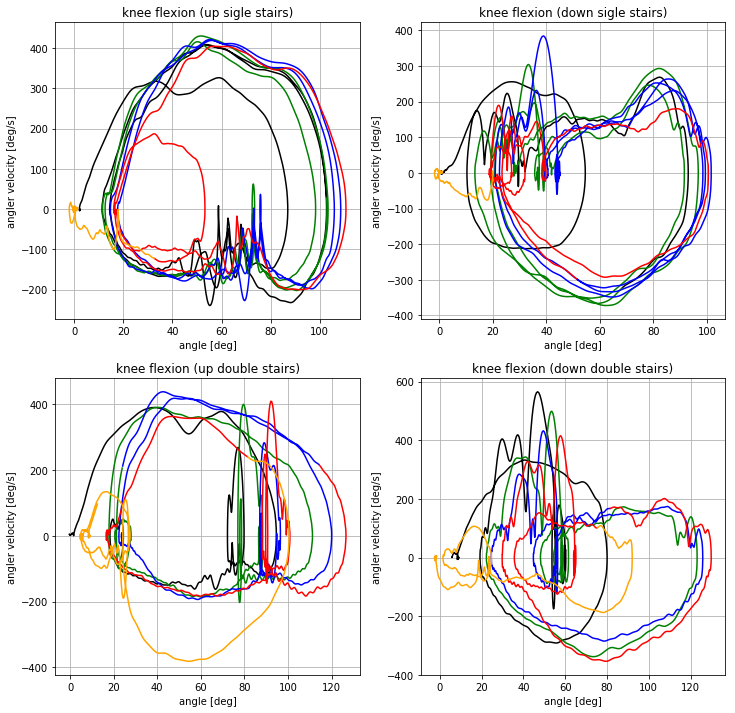

In [23]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)    #パレットを2行2列に分割し，一番左上に以下のグラフを描く
plt.plot(theta[2000:5000], omega[2000:5000], c='black')
plt.plot(theta[5000:7500], omega[5000:7500], c='green')
plt.plot(theta[7500:10000], omega[7500:10000], c='blue')
plt.plot(theta[10000:12500], omega[10000:12500], c='red')
plt.plot(theta[12500:15000], omega[12500:15000], c='orange')
plt.title('knee flexion (up sigle stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(theta[14000:17000], omega[14000:17000], c='black')
plt.plot(theta[17000:20000], omega[17000:20000], c='green')
plt.plot(theta[20000:23000], omega[20000:23000], c='blue')
plt.plot(theta[23000:26000], omega[23000:26000], c='red')
plt.plot(theta[26000:28000], omega[26000:28000], c='orange')
plt.title('knee flexion (down sigle stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(theta[52000:54000], omega[52000:54000], c='black')
plt.plot(theta[54000:56000], omega[54000:56000], c='green')
plt.plot(theta[56000:58000], omega[56000:58000], c='blue')
plt.plot(theta[58000:60000], omega[58000:60000], c='red')
plt.plot(theta[60000:64000], omega[60000:64000], c='orange')
plt.title('knee flexion (up double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(2, 2, 4)    #パレットを2行2列に分割し，一番右下に以下のグラフを描く
plt.plot(theta[63000:65000], omega[63000:65000], c='black')
plt.plot(theta[65000:67000], omega[65000:67000], c='green')
plt.plot(theta[67000:69000], omega[67000:69000], c='blue')
plt.plot(theta[69000:71000], omega[69000:71000], c='red')
plt.plot(theta[71000:74000], omega[71000:74000], c='orange')
plt.title('knee flexion (down double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()


◼️4-5.　１組の波形群からティピカルな１周期分をとりだして，位相空間内の膝屈曲角運動の軌跡を描いてみよう：

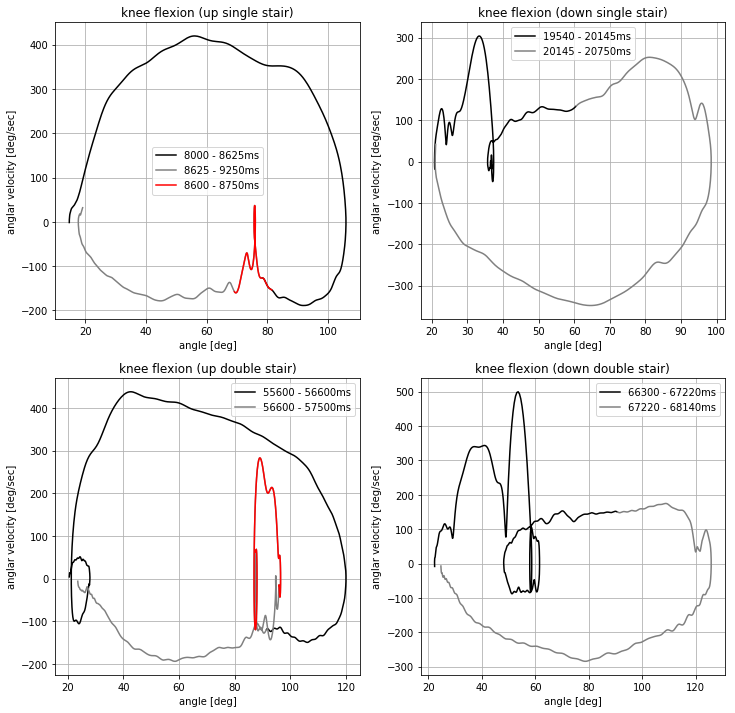

In [24]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.plot(theta[8000:8625], omega[8000:8625], c='black')
plt.plot(theta[8625:9250], omega[8625:9250], c='gray')
plt.plot(theta[8600 : 8750], omega[8600 : 8750], c='red')
plt.legend(['8000 - 8625ms', '8625 - 9250ms', '8600 - 8750ms'])
plt.title('knee flexion (up single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(theta[19540:20145], omega[19540:20145], c='black')
plt.plot(theta[20145:20750], omega[20145:20750], c='gray')
plt.legend(['19540 - 20145ms', '20145 - 20750ms'])
plt.title('knee flexion (down single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(theta[55600:56600], omega[55600:56600], c='black')
plt.plot(theta[56600:57500], omega[56600:57500], c='gray')
plt.plot(theta[56640:56750], omega[56640:56750], c='red')
plt.legend(['55600 - 56600ms', '56600 - 57500ms'])
plt.title('knee flexion (up double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(theta[66300:67220], omega[66300:67220], c='black')
plt.plot(theta[67220:68140], omega[67220:68140], c='gray')
plt.legend(['66300 - 67220ms', '67220 - 68140ms'])
plt.title('knee flexion (down double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

## ５．衝撃加速度と屈曲角運動

◼️5-1. 階段昇降実験の場合，昇降時に足底が階段に着地した瞬間に衝撃加速度が生じるはずである。それを確かめるために，データフレーム`df1`, `df2`から加速度部分を取り出して，numpy配列に直しておく：

In [45]:
a1_x = np.array(df['a1_x']/10000)[1500:]
a1_y = np.array(df['a1_y']/10000)[1500:]
a1_z = np.array(df['a1_z']/10000)[1500:]
a2_x = np.array(df['a2_x']/10000)[1500:]
a2_y = np.array(df['a1_y']/10000)[1500:]
a2_z = np.array(df['a1_z']/10000)[1500:]

> ローパスフィルタ処理は施さない。なぜなら，衝撃は非常に短い時間に起こるので，下手に周波数フィルタリングをかけると，それを取り損ねてしまうそれがあるからだ。また，各々の配列を1500インデックスから始めているのは，

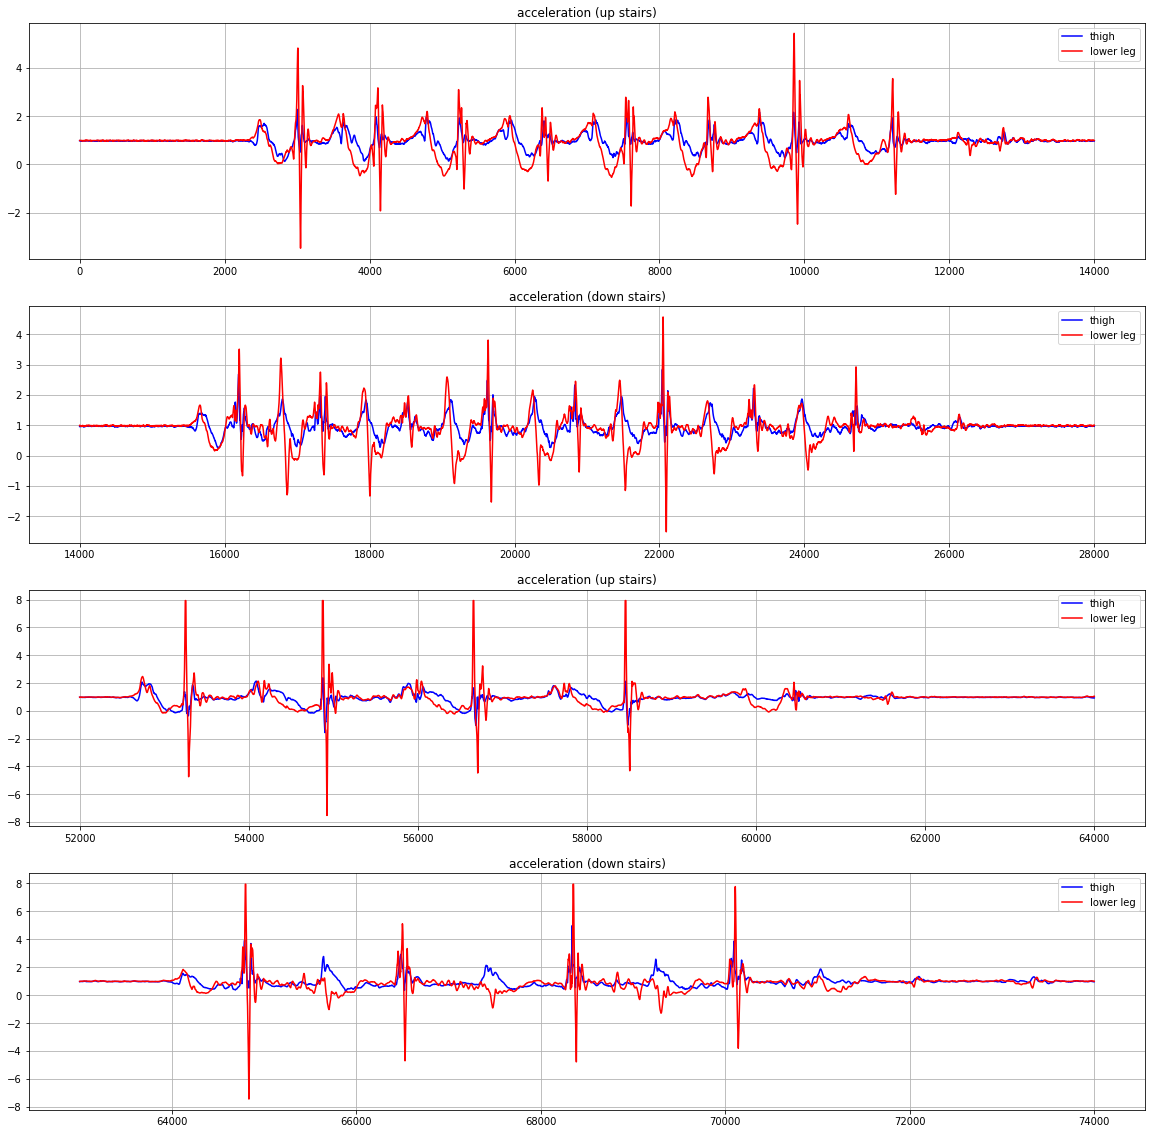

In [46]:
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)
plt.plot(np.arange(14000), a1_x[:14000], c='blue')
plt.plot(np.arange(14000), a2_x[:14000], c='red')
plt.title('acceleration (up stairs)')
plt.legend(['thigh', 'lower leg'])
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(np.arange(14000, 28000), a1_x[14000:28000], c='blue')
plt.plot(np.arange(14000, 28000), a2_x[14000:28000], c='red')
plt.title('acceleration (down stairs)')
plt.legend(['thigh', 'lower leg'])
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(np.arange(52000, 64000), a1_x[52000:64000], c='blue')
plt.plot(np.arange(52000, 64000), a2_x[52000:64000], c='red')
plt.title('acceleration (up stairs)')
plt.legend(['thigh', 'lower leg'])
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(np.arange(63000, 74000), a1_x[63000:74000], c='blue')
plt.plot(np.arange(63000, 74000), a2_x[63000:74000], c='red')
plt.title('acceleration (down stairs)')
plt.legend(['thigh', 'lower leg'])
plt.grid()

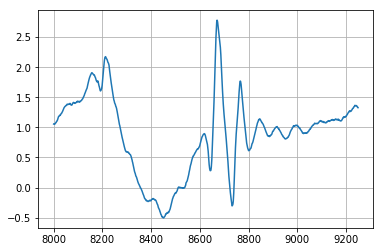

In [65]:
plt.plot(np.arange(8000, 9250), a2_x[8000:9250])
plt.grid()

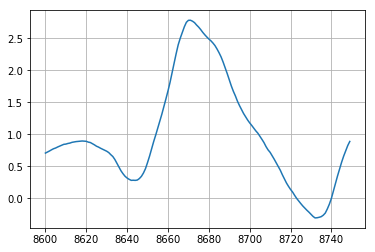

In [74]:
plt.plot(np.arange(8600, 8750), a2_x[8600:8750])
plt.grid()

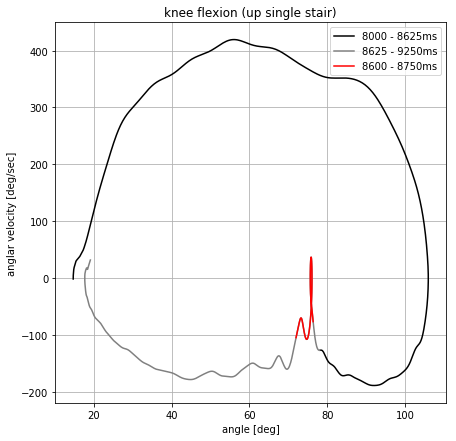

In [76]:
plt.figure(figsize=(7,7))
plt.plot(theta[8000:8625], omega[8000:8625], c='black')
plt.plot(theta[8625:9250], omega[8625:9250], c='gray')
plt.plot(theta[8640 : 8730], omega[8640 : 8730], c='red')
plt.legend(['8000 - 8625ms', '8625 - 9250ms', '8600 - 8750ms'])
plt.title('knee flexion (up single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

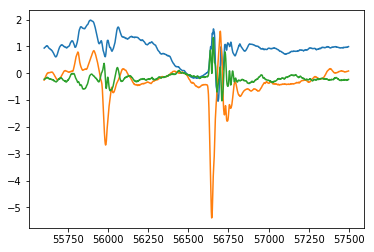

In [48]:
plt.plot(np.arange(55600,57500), a1_x[55600:57500])
plt.plot(np.arange(55600,57500), a1_y[55600:57500])
plt.plot(np.arange(55600,57500), a1_z[55600:57500])

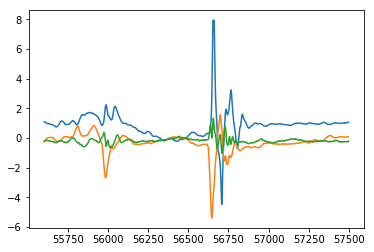

In [49]:
plt.plot(np.arange(55600,57500), a2_x[55600:57500])
plt.plot(np.arange(55600,57500), a2_y[55600:57500])
plt.plot(np.arange(55600,57500), a2_z[55600:57500])

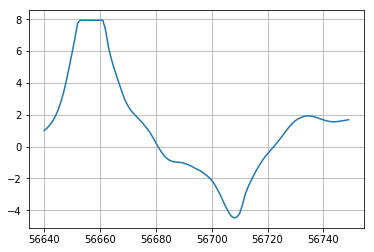

In [50]:
plt.plot(np.arange(56640,56750), a2_x[56640:56750])
plt.grid()

In [51]:
da1_x = np.diff(a1_x)/0.001
da1_y = np.diff(a1_y)/0.001

In [52]:
da1_x

array([-2.6, -5.9,  4.6, ...,  2.2, -8.8,  1.5])

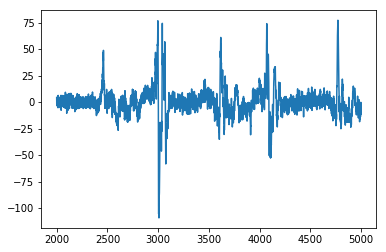

In [55]:
plt.plot(np.arange(2000,5000), da1_x[2000:5000])

In [78]:
np.arange(14000, 28000)

array([14000, 14001, 14002, ..., 27997, 27998, 27999])